In [118]:
import numpy as np
import xroms
from glob import glob
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import xrft
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle

from dask.diagnostics import ProgressBar
import dask
from dask.distributed import Client, LocalCluster

import scipy.integrate as integ
# warnings.filterwarnings("ignore")
import seawater as sw
from scipy.interpolate import interp1d

In [2]:
#plot specs

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']


In [3]:
# client = Client(processes=False)


In [4]:
# client

In [5]:

def xr_pden(s,t,p,xr_coords,xr_dims,pr=0):
    pden=sw.pden(s=s,t=t,p=p,pr=pr)
    return xr.DataArray(pden,coords=xr_coords,dims=xr_dims)

In [6]:
# chunks={'time_counter':10, 'x_rho':50, 'y_rho':190,'s_rho':80,'s_w':80}
chunks={'time_counter':1,'x_rho':1000,"x_u":1000,"x_v":1000,
                        'y_rho':1520,"y_u":1520,"y_v":1520,'s_rho':80,'s_w':80}

M='01'
path='/data/pacific/lrenault/SASI/CROCO/'

varf=xr.open_mfdataset(path + 'FULL/SASI*2012-{0}*.nc'.format(M),data_vars='minimal',chunks=chunks)
vart=xr.open_mfdataset(path + 'SMTH/SASI*2012-{0}*.nc'.format(M),data_vars='minimal',chunks=chunks)

# varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal',chunks=chunks)
# vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal',chunks=chunks)

In [7]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=varx.Vtransform.data)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=vary.Vtransform.data)

/tmp/ipykernel_1793259/2400411198.py:1: UserWarning: rename 's_rho' to 's_rho' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
/tmp/ipykernel_1793259/2400411198.py:1: UserWarning: rename 's_w' to 's_w' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
/tmp/ipykernel_1793259/2400411198.py:5: UserWarning: rename 's_rho' to 's_rho' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
/tmp/ipykernel_1793259/2400411198.py:5: UserWarning: rename 's_w' to 's_w' does n

In [8]:
timer_h=pd.DatetimeIndex(dt.ocean_time)
timer_d=pd.DatetimeIndex(dt.ocean_time.groupby("ocean_time.dayofyear").mean())

In [9]:
ix=0

In [10]:
temp_full=df.temp[ix,:,120:-120,120:800]
temp_smth=dt.temp[ix,:,120:-120,120:800]

salt_full=df.salt[ix,:,120:-120,120:800]
salt_smth=dt.salt[ix,:,120:-120,120:800]

In [11]:
%%time
# rho_full=df.rho[ix,:,120:-120,120:800]+df.rho0
# rho_smth=dt.rho[ix,:,120:-120,120:800]+dt.rho0

# rho_full=xr_pden(s=salt_full.compute()[::-1,:,:],t=temp_full.compute()[::-1,:,:],p=-temp_full.z_rho0.compute()[::-1,:,:],
#                  xr_coords=temp_full.compute()[::-1,:,:].coords,xr_dims=temp_full.compute()[::-1,:,:].dims,pr=0)
# rho_smth=xr_pden(s=salt_smth.compute()[::-1,:,:],t=temp_smth.compute()[::-1,:,:],p=-temp_smth.z_rho0.compute()[::-1,:,:],
#                  xr_coords=temp_smth.compute()[::-1,:,:].coords,xr_dims=temp_smth.compute()[::-1,:,:].dims,pr=0)

rho_full=temp_full.copy(data=sw.pden(s=salt_full,t=temp_full,p=-temp_full.z_rho,pr=0))
rho_smth=temp_full.copy(data=sw.pden(s=salt_smth,t=temp_smth,p=-temp_smth.z_rho,pr=0))

CPU times: user 14.8 s, sys: 6.51 s, total: 21.4 s
Wall time: 21.4 s


In [12]:
b_full=xroms.buoyancy(rho_full-1025,rho0=1025)
b_smth=xroms.buoyancy(rho_smth-1025,rho0=1025)

In [13]:
zSurf=temp_full.z_rho0.compute().max()
zBott=temp_full.z_rho0.compute().min()

In [201]:
z_surf_interp=-2
dz=2
z_interp=np.linspace(z_surf_interp,zBott, np.int(np.abs(zBott/dz)))
print('dz={0:.1f}'.format(np.diff(z_interp).mean()) +  '   n_z={0:.0f}'.format(np.int(np.abs(zBott/dz))))

dz=-2.0   n_z=2535


/tmp/ipykernel_1793259/4068299948.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z_interp=np.linspace(z_surf_interp,zBott, np.int(np.abs(zBott/dz)))
/tmp/ipykernel_1793259/4068299948.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

In [202]:
%%time
dec=1


Zstar_full=xr.DataArray(coords=(
                                z_interp,
                                rho_full.eta_rho.data,
                                rho_full.xi_rho.data),
                      dims=['z_rho','eta_rho','xi_rho'])


CPU times: user 810 ms, sys: 14.8 s, total: 15.6 s
Wall time: 16.4 s


In [203]:
Z_matrix=xr.DataArray(coords=(
                                z_interp,
                                rho_full.eta_rho.data,
                                rho_full.xi_rho.data),
                      dims=['z_rho','eta_rho','xi_rho'])
Z_matrix[:,:,:]=z_interp[:,None,None]

In [204]:
'Interp'

# xx=(b_full['xi_rho'].data-b_full['xi_rho'].data[0])*500
# Nx=len(xx)
# zz=z_interp
# Nz=len(zz)
# yy=(b_full['eta_rho'].data-b_full['eta_rho'].data[0])*500
# Ny=len(yy)
d_field=rho_full[:,:,:].xroms.isoslice(z_interp).compute()

DeltaX=(d_field*0+500).compute()
DeltaY=(d_field*0+500).compute()
DeltaZ=xr.apply_ufunc(np.gradient,d_field['z_rho'],kwargs={'axis':0})
DeltaA=DeltaX*DeltaY
DeltaV=np.abs(DeltaA*DeltaZ)

In [205]:
V=DeltaV.sum()
Az=DeltaA.sum(['eta_rho','xi_rho'])
Vz=DeltaV.sum(['eta_rho','xi_rho'])


In [206]:
%%time
# b_interp=b_full[:,:,:].xroms.isoslice(z_interp).compute()
# b_flat=np.ravel(b_interp)
rho_interp=rho_full[:,:,:].xroms.isoslice(z_interp).compute()
rho_flat=np.ravel(b_interp)


z_flat=np.ravel(Z_matrix)

sort_idx = np.argsort(rho_flat)
b_sorted, z_sorted = rho_flat[sort_idx], z_flat[sort_idx]

DeltaV_flat = np.ravel(DeltaV)[sort_idx]

In [207]:
%%time
# b_flat_nonan=b_interp.stack(ravel=['xi_rho','eta_rho','z_rho']).dropna(dim='ravel')
rho_flat_nonan=rho_interp.stack(ravel=['xi_rho','eta_rho','z_rho']).dropna(dim='ravel')

CPU times: user 1min 12s, sys: 2min 39s, total: 3min 51s
Wall time: 3min 56s


In [208]:
%%time
# count, bins_count=np.histogram(b_flat_nonan,bins=b_flat_nonan.shape[0])
# count, bins_count=np.histogram(b_flat_nonan,bins=1000)

count, bins_count=np.histogram(rho_flat_nonan,bins=1000)

CPU times: user 13.1 s, sys: 606 µs, total: 13.1 s
Wall time: 13.2 s


In [209]:
%%time
P_rho=count/sum(count)

CPU times: user 548 µs, sys: 0 ns, total: 548 µs
Wall time: 481 µs


In [210]:
A_Az=integ.cumtrapz(Az[::-1],dx=np.diff(-z_interp)[0])[::-1]
V_PDF=(np.cumsum(P_rho[::-1])*V.data)[::-1]
b_v_PDF=(bins_count[1:]+bins_count[:-1])/2

In [211]:
%%time
rho_zr=[]
zr=[]

for k in range(V_PDF.shape[0]):
    rho_zr.append(b_v_PDF[k])
    z_i=np.argmin(np.abs((A_Az-V_PDF[k])))
    zr.append(z_interp[z_i])
    
Zr=np.array(zr)
Rho_zr=np.array(rho_zr)

CPU times: user 8.87 ms, sys: 0 ns, total: 8.87 ms
Wall time: 8.51 ms


In [234]:
%%time
FF = interp1d(Rho_zr,Zr,fill_value='extrapolate')

CPU times: user 92 µs, sys: 153 µs, total: 245 µs
Wall time: 231 µs


Text(0.5, 0, '$z^*$')

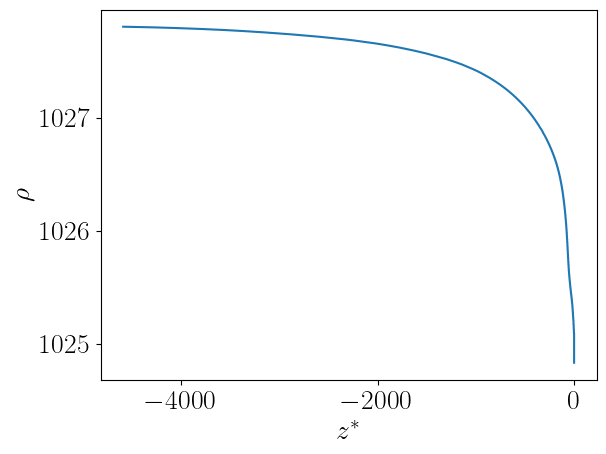

In [237]:
plt.plot(Zr,Rho_zr)
plt.ylabel(r'$\rho$')
plt.xlabel(r'$z^*$')

In [236]:
%%time
Zr_full=FF(rho_interp)

CPU times: user 51.8 s, sys: 14.7 s, total: 1min 6s
Wall time: 1min 6s


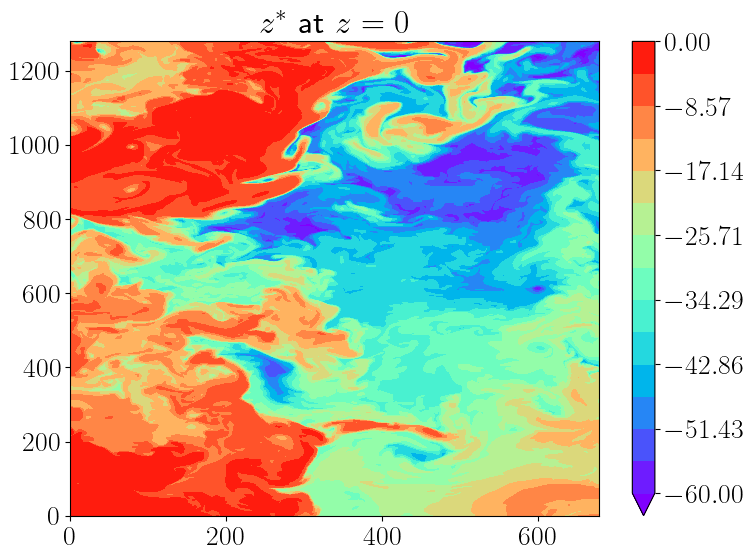

In [241]:

plt.figure(figsize=(8,6))
# plt.contourf(rho_full['nav_lon_rho'],rho_full['nav_lat_rho'],Zr_full[0,:,:],levels=np.linspace(-60,0,15),extend='both',cmap='rainbow')
plt.contourf(Zr_full[0,:,:],levels=np.linspace(-60,0,15),extend='min',cmap='rainbow')

plt.colorbar()
plt.title(r'$z^*$ at $z=0$')
plt.tight_layout()

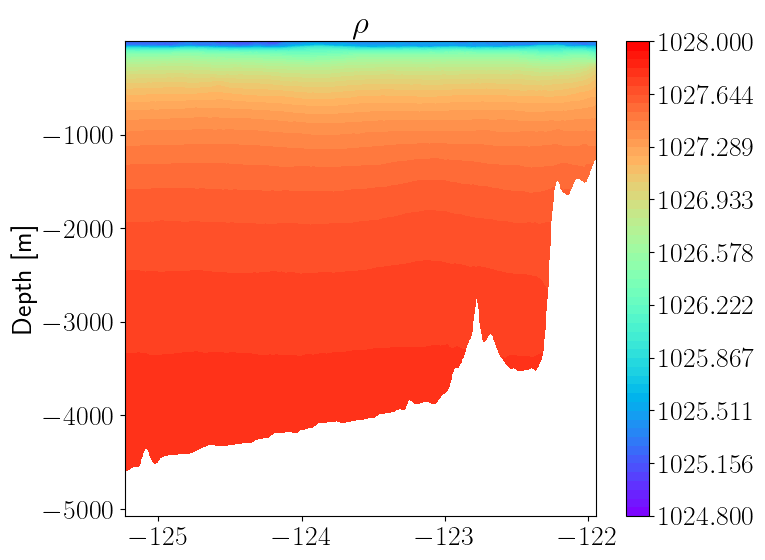

In [252]:

plt.figure(figsize=(8,6))
plt.contourf(rho_interp['nav_lon_rho'][300,:],rho_interp['z_rho'],rho_interp[:,300,:],levels=np.linspace(1024.8,1028,55),cmap='rainbow')
plt.colorbar()
plt.title(r'$\rho$')
plt.ylabel('Depth [m]')
plt.tight_layout()

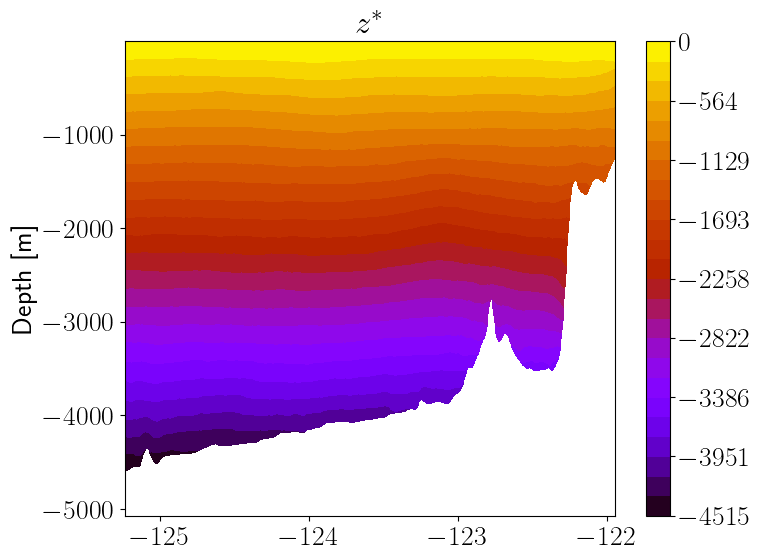

In [240]:

plt.figure(figsize=(8,6))
plt.contourf(rho_interp['nav_lon_rho'][300,:],rho_interp['z_rho'],Zr_full[:,300,:],np.linspace(np.nanmin(Zr_full[:,300,:]),0,25),cmap='gnuplot')
plt.colorbar()
plt.title(r'$z^*$')
plt.ylabel('Depth [m]')
plt.tight_layout()

In [90]:
A_interp = interp1d(z_interp, Az,fill_value='extrapolate')

In [ ]:
Zr=np.cumsum(P_rho) - Az/V

ValueError: operands could not be broadcast together with shapes (1000,) (101,) 

In [107]:
%%time
dv=DeltaV[0,0,0]
zstar_flat_pdf = np.zeros_like(P_rho)
zstar_flat_pdf[-1]=np.nanmin(z_interp)


# for k in np.arange(0,P_rho.shape[0]-1)[::-1]:
#     A_i = A_interp(zstar_flat_pdf[k+1])
#     zstar_flat_pdf[k]=(zstar_flat_pdf[k+1] +dv/A_i)

    
for k in np.arange(0,Az.shape[0])[::-1]:
    # A_i = A_interp(zstar_flat_pdf[k+1])
    zstar_flat_pdf[k]=(zstar_flat_pdf[k+1] +dv/Az[k])
    

CPU times: user 327 ms, sys: 8.18 ms, total: 335 ms
Wall time: 768 ms


In [ ]:
Zr=

In [31]:
%%time
A_b=DeltaA.sum(['eta_rho','xi_rho'])
A_interp = interp1d(z_interp, A_b,fill_value='extrapolate')
zstar_flat = np.zeros_like(b_sorted)
zstar_flat[-1]=(z_interp[1]/np.abs(z_interp[1]))*np.max(np.abs(z_interp))


CPU times: user 219 ms, sys: 153 ms, total: 372 ms
Wall time: 367 ms


In [32]:
%%time
for k in np.arange(0,b_sorted.shape[0]-1)[::-1]:
    A = A_interp(zstar_flat[k+1])
    # A=A_b[k+1].copy()
    zstar_flat[k]=(zstar_flat[k+1] + DeltaV_flat[k]/A)
# zstar_flat = np.ravel(z_matrix)

unsort_idx = np.argsort(sort_idx)
zstar = zstar_flat[unsort_idx].reshape(Z_matrix.shape)


CPU times: user 37min 20s, sys: 1min 20s, total: 38min 41s
Wall time: 37min 44s


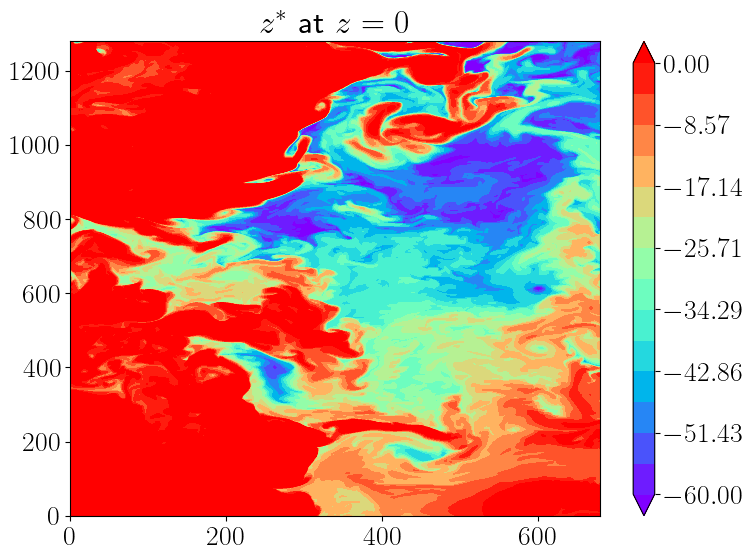

In [35]:

plt.figure(figsize=(8,6))
plt.contourf(zstar[0,:,:],levels=np.linspace(-60,0,15),extend='both',cmap='rainbow')
plt.colorbar()
plt.title(r'$z^*$ at $z=0$')
plt.tight_layout()

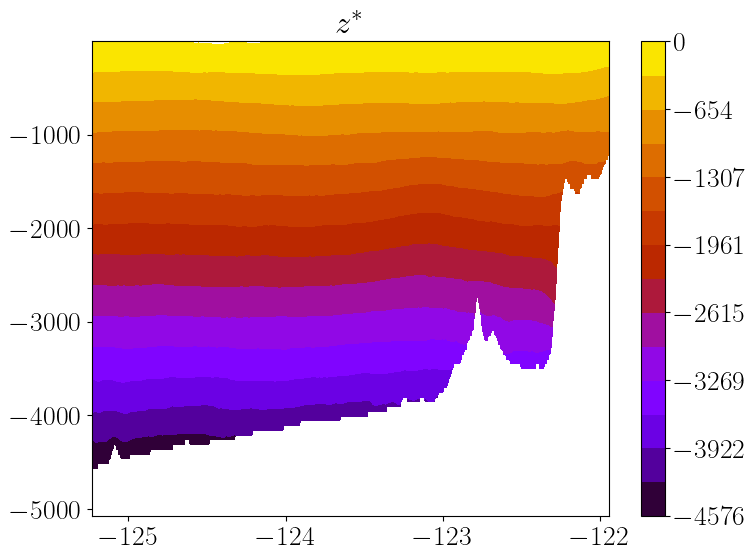

In [36]:
# plt.figure()
# plt.contourf(xx,z_interp,b_interp[:,300,:],levels=np.linspace(np.nanmin(b_interp[:,300,:]),np.nanmax(b_interp[:,300,:]),15))
# plt.colorbar()


plt.figure(figsize=(8,6))
plt.contourf(b_full['nav_lon_rho'][300,:],z_interp,zstar[:,300,:],np.linspace(np.nanmin(zstar[:,300,:]),0,15),cmap='gnuplot')
plt.colorbar()
plt.title(r'$z^*$')
plt.tight_layout()

In [33]:
%%time
rho_full_interp=rho_full[:,:,:].xroms.isoslice(z_interp).compute() #interpolating p dens to the maximum depth possible

rho_full_stacked=np.ravel(rho_full_interp) #flatten rho grid
index_sorted_full=np.argsort(rho_full_stacked) #sort rho vector
rho_sorted_full=np.argsort(rho_full_stacked) #sort rho vector

nan_stacked=np.isnan(rho_full_stacked) #keep track of the nan locations



CPU times: user 1min 37s, sys: 1.64 s, total: 1min 39s
Wall time: 1min 34s


In [34]:
%%time
rho_sorted_full=np.sort(rho_full_stacked) #sort rho vector

CPU times: user 33.8 s, sys: 247 ms, total: 34.1 s
Wall time: 34.1 s


In [35]:
%%time
rho_full_stacked_nansmart=data_filler(data_sort=rho_sorted_full,nan_sort=nan_stacked)

CPU times: user 9min 32s, sys: 5.81 s, total: 9min 37s
Wall time: 9min 39s


In [36]:
%%time
rho_star_nansmart=rho_full_interp.copy(data=rho_full_stacked_nansmart[index_sorted_full].reshape(rho_full_interp.shape))
rho_star=rho_full_interp.copy(data=rho_full_stacked[index_sorted_full].reshape(rho_full_interp.shape))

rho_star_m=rho_full_interp.copy(data=np.tile(rho_star.mean(['xi_rho','eta_rho']),
                                             (rho_full_interp.shape[2],rho_full_interp.shape[1],1)).T)


CPU times: user 5.44 s, sys: 1.04 s, total: 6.48 s
Wall time: 6.49 s


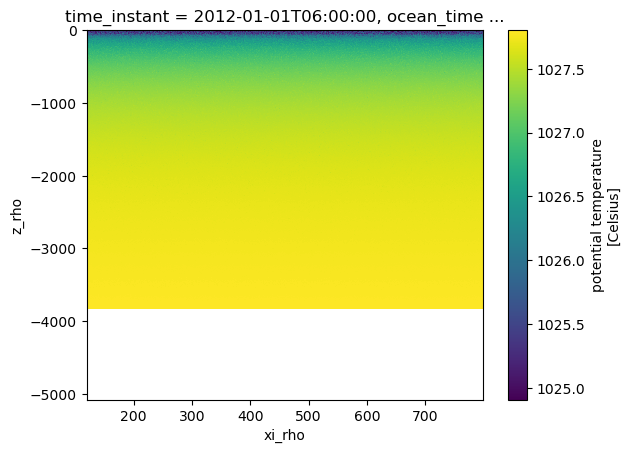

In [48]:
rho_star_nansmart[:,600,:].plot()

(1026.0, 1028.0)

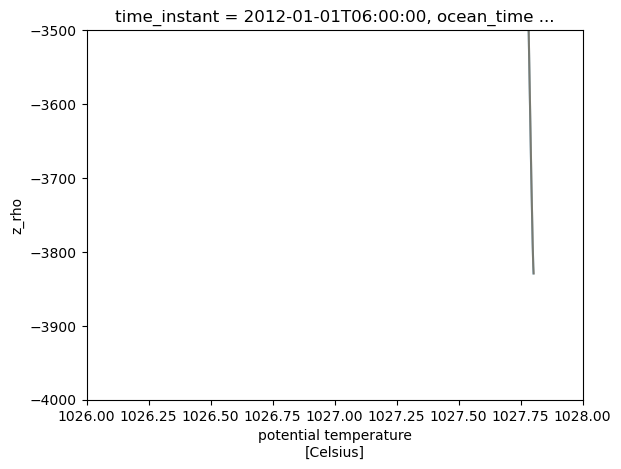

In [46]:
rho_star_nansmart.mean(['eta_rho','xi_rho']).plot(y='z_rho',alpha=1)
rho_star.mean(['eta_rho','xi_rho']).plot(y='z_rho',alpha=0.4)
plt.ylim(-4000,-3500)
plt.xlim(1026,1028)

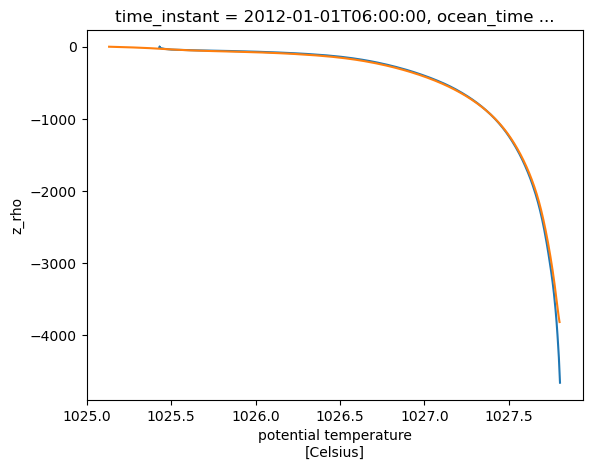

In [29]:
rho_full_interp[:,600,:].mean(axis=1).plot(y='z_rho')
rho_star[:,600,:].mean(axis=1).plot(y='z_rho')
# rho_full_interp[:,600,:].plot()
# plt.figure()
# rho_star[:,600,:].plot()

### Method of argsort

In [ ]:

# Rho_full_interp[day_x,:,:,:]=rho_full_interp

"numpy method (working but janky)"
rho_full_stacked=np.ravel(rho_full_interp)
index_sorted_full=np.argsort(rho_full_stacked)

rho_star=rho_full_interp.copy(data=rho_full_stacked[index_sorted_full].reshape(rho_full_interp.shape))
rho_star_m=rho_full_interp.copy(data=np.tile(rho_star.mean(['xi_rho','eta_rho']),
                                             (rho_full_interp.shape[2],rho_full_interp.shape[1],1)).T)


In [197]:
%%time

rho_full_interp=rho_full[:,:,:].xroms.isoslice(z_interp).compute()
# Rho_full_interp[day_x,:,:,:]=rho_full_interp

"numpy method (working but janky)"
rho_full_stacked=np.ravel(rho_full_interp)
index_sorted_full=np.argsort(rho_full_stacked)

rho_star=rho_full_interp.copy(data=rho_full_stacked[index_sorted_full].reshape(rho_full_interp.shape))
rho_star_m=rho_full_interp.copy(data=np.tile(rho_star.mean(['xi_rho','eta_rho']),
                                             (rho_full_interp.shape[2],rho_full_interp.shape[1],1)).T)

for zi in range(z_interp.shape[0]):
    Zstar_full[zi,:,:]=z_interp[(np.abs(rho_full_interp[zi,:,:]-rho_star_m)).argmin('z_rho')]

ValueError: All-NaN slice encountered

In [31]:
# z_matrix=np.zeros([z_interp.shape[0],rho_full.shape[2],rho_full.shape[3]])
z_matrix=np.zeros([z_interp.shape[0],rho_full.shape[1],rho_full.shape[2]])
# z_matrix[:,:,:]=-z_interp[:,None,None]

In [32]:
dec=1
Zstar_full=xr.DataArray(coords=(df.ocean_time[::dec],
                                z_interp,
                                rho_full.eta_rho.data,
                                rho_full.xi_rho.data),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])

Rho_full_interp=xr.DataArray(coords=(df.ocean_time[::dec],
                                z_interp,
                                rho_full.eta_rho.data,
                                rho_full.xi_rho.data),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])

In [ ]:
%%time
"NEW METHOD"


for day_x in range(rho_full.ocean_time.shape[0]):


    rho_full_interp=rho_full[day_x,:,:,:].xroms.isoslice(z_interp).compute()
    # rho_full_interp['z_rho']=z_interp
    Rho_full_interp[day_x,:,:,:]=rho_full_interp

    "numpy method (working but janky)"
    rho_full_stacked=np.ravel(rho_full_interp)
    index_sorted_full=np.argsort(rho_full_stacked)

    rho_star=rho_full_interp.copy(data=rho_full_stacked[index_sorted_full].reshape(rho_full_interp.shape))
    rho_star_m=rho_full_interp.copy(data=np.tile(rho_star.mean(['xi_rho','eta_rho']),
                                                 (rho_full_interp.shape[2],rho_full_interp.shape[1],1)).T)

    for zi in range(z_interp.shape[0]):
        Zstar_full[day_x,zi,:,:]=z_interp[(np.abs(rho_full_interp[zi,:,:]-rho_star_m)).argmin('z_rho')]

In [ ]:
%%time
Zstar_full.to_netcdf('/data/pacific/iufarias/z_star/z_star_full_newmethod_M{0}.nc'.format(M))
del Zstar_full

In [ ]:
%%time
Rho_full_interp.to_netcdf('/data/pacific/iufarias/z_star/rho_full_M{0}.nc'.format(M))
del Rho_full_interp

In [ ]:
Zstar_smth=xr.DataArray(coords=(dt.ocean_time[::dec],
                                z_interp,
                                rho_smth.eta_rho,
                                rho_smth.xi_rho),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])

Rho_smth_interp=xr.DataArray(coords=(dt.ocean_time[::dec],
                                z_interp,
                                rho_smth.eta_rho,
                                rho_smth.xi_rho),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])

In [ ]:
%%time
"NEW METHOD"
for day_x in range(rho_smth.ocean_time.shape[0]):


    rho_smth_interp=rho_smth[day_x,:,:,:].xroms.isoslice(z_interp).compute()
    # rho_smth_interp['z_rho']=z_interp_rev
    Rho_smth_interp[day_x,:,:,:]=rho_smth_interp

    "numpy working hod (working but janky)"
    rho_smth_stacked=np.ravel(rho_smth_interp)
    index_sorted_smth=np.argsort(rho_smth_stacked)

    rho_star=rho_smth_interp.copy(data=rho_smth_stacked[index_sorted_smth].reshape(rho_smth_interp.shape))
    rho_star_m=rho_smth_interp.copy(data=np.tile(rho_star.mean(['xi_rho','eta_rho']),
                                                 (rho_smth_interp.shape[2],rho_smth_interp.shape[1],1)).T)

    for zi in range(z_interp.shape[0]):
        Zstar_smth[day_x,zi,:,:]=z_interp[(np.abs(rho_smth_interp[zi,:,:]-rho_star_m)).argmin('z_rho')]

In [ ]:
%%time
Zstar_smth.to_netcdf('/data/pacific/iufarias/z_star/z_star_smth_newmethod_M{0}.nc'.format(M))
del Zstar_smth

In [ ]:
%%time
Rho_smth_interp.to_netcdf('/data/pacific/iufarias/z_star/rho_smth_M{0}.nc'.format(M))
del Rho_smth_interp